# Preparing the training data

The idea here is to use the [official AFD training data](https://docs.aws.amazon.com/frauddetector/latest/ug/samples/training_data.zip) and amend it in two dimensions:
1. Add a new feature *registration time* that indicates how long the user took to filling and submit the registration form. The basic idea is that bots are much more likely to take much less time to register as they aim to create multiple fake accounts in a short amount of time
1. Manipulate the email addresses so that fraudulent sign-ups are much more likely to use a randomised string as user name

In [3]:
!pwd

/home/ec2-user/SageMaker/amazon-fraud-detector-bot-detection-demo/notebooks


## Download of data and import of required packages

In [4]:
!mkdir data
!curl https://docs.aws.amazon.com/frauddetector/latest/ug/samples/training_data.zip --output ./data/training_data.zip
!unzip -o ./data/training_data.zip -d ./data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1504k  100 1504k    0     0  4426k      0 --:--:-- --:--:-- --:--:-- 4439k
Archive:  ./data/training_data.zip
  inflating: ./data/registration_data_20K_full.csv  
  inflating: ./data/registration_data_20K_minimum.csv  


In [5]:
!pip install zxcvbn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.9/407.9 kB 7.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for zxcvbn: filename=zxcvbn-4.4.28-py2.py3-none-any.whl size=408125 sha256=a9fe3d0208eb44bb2c69a91c102958b69c7ed04b1d6afe5c32ac5aa3ca87732d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ef/89/c6/a0e065af99073821bb4b83f6ec0561e981fc00498fe8e9c45d
Successfully built zxcvbn


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import string
import secrets
from zxcvbn import zxcvbn

This function creates a random string between 6 and 12 characters long

In [7]:
def create_random_uname():
    len = np.random.randint(6, 12)
    uname = ''.join(secrets.choice(string.ascii_lowercase) for _ in range(len))
    return uname

## Manipulating the training data

In [8]:
df = pd.read_csv('data/registration_data_20K_minimum.csv')

This cell will distribute new labels to the data set -- 90% of the observations will be labelled *legitimate* and 10% will be labelled *fraudulent*.

In [9]:
df['random1'] = np.random.rand(df.shape[0])
df['random2'] = np.random.rand(df.shape[0])
df['new_label'] = df['random1'].apply(lambda x: 'legit' if x <= .9 else 'fraud')
df['registration_time'] = 0

This cell will populate the new features (registration_time & user name) for the legitimate observations. The registration time will be distributed in a skew normal distribution with a long tail to account for users that take longer to complete the registration form. The user name for legitimate sign-ups will stay the same as in the original data set 95% of the time. In 5% of the cases the user name will be a random string.

In [10]:
pd.options.mode.chained_assignment = None 
df_legit = df[df['new_label'] == 'legit']
df_legit['registration_time'] = skewnorm.rvs(10, loc=7000, scale=15000, size=df_legit.shape[0])
df_legit['new_email'] = df_legit['email_address'].str[5:]
df_legit['email_uname'] = df_legit['new_email'].apply(lambda x: x.split('@')[0])
df_legit['email_domain'] = df_legit['new_email'].apply(lambda x: x.split('@')[1])
df_legit['new_uname'] = df_legit.apply(lambda x: x['email_uname'] if x['random2'] <= .95 else create_random_uname(), axis=1)

For fraudulent observations the registration time will be much shorter (skew noraml distribution with 2000 ms as center) and in 95% of the cases the user name will be a random string.

In [14]:
df_fraud = df[df['new_label'] == 'fraud']
df_fraud['registration_time'] = skewnorm.rvs(4, loc=2000, scale=2000, size=df_fraud.shape[0])
df_fraud['new_email'] = df_fraud['email_address'].str[5:]
df_fraud['email_uname'] = df_fraud['new_email'].apply(lambda x: x.split('@')[0])
df_fraud['email_domain'] = df_fraud['new_email'].apply(lambda x: x.split('@')[1])
df_fraud['new_uname'] = df_fraud.apply(lambda x: x['email_uname'] if x['random2'] >= .95 else create_random_uname(), axis=1)

In [15]:
#df = df_legit.append(df_fraud)
df = pd.concat([df_legit, df_fraud], ignore_index=True)
df = df.sort_index()

In this demo the email domain will be the same for all observations so that the model will be able to pick up on the randomness of the user name as a useful signal. But of course it might be worthwhile to amend the email domain as well to add another dimension to the model.

In [16]:
df['new_email'] = df['new_uname'] + '@example.com'

Capping the registration time so that there will be no negative values 

In [17]:
df['registration_time'] = df['registration_time'].apply(lambda x: 100 if x < 100 else x)
df['registration_time'] = df['registration_time'].apply(int)
df['EVENT_LABEL'] = df['new_label']

Calculates the randomness of the user names, which will be used later to visualise the data along this dimension

In [18]:
df['randomness_uname'] = df['new_uname'].apply(lambda x: zxcvbn(x)['guesses_log10'] + (np.random.rand() - .5))

Writing the training data into a csv file

In [19]:
df_out = df[['ip_address', 'new_email', 'registration_time', 'EVENT_TIMESTAMP', 'new_label']]
df_out.columns = ['ip_address', 'email_address', 'registration_time', 'EVENT_TIMESTAMP', 'EVENT_LABEL']
df_out.to_csv('data/afd_training_data.csv', index=False)

In [20]:
df_out.head()

,ip_address,email_address,registration_time,EVENT_TIMESTAMP,EVENT_LABEL
0,46.41.252.160,acostasusan@example.com,7470,10/8/2019 20:44,legit
1,152.58.247.12,christopheryoung@example.com,35891,5/23/2020 19:44,legit
2,12.252.206.222,jeffrey09@example.com,20574,4/24/2020 18:26,legit
3,170.81.164.240,ncastro@example.com,8240,4/22/2020 19:07,legit
4,165.182.68.217,charles99@example.com,11117,12/31/2019 17:08,legit


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

## Plotting the training data

First, the data will be plotted along the registration time feature to visualise the distribution for legitimate vs fraudulent sign-ups

/tmp/ipykernel_10815/3312238232.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['new_label'] == 'legit']['registration_time'])
/tmp/ipykernel_10815/3312238232.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['new_label'] == 'fraud']['registration_time'])


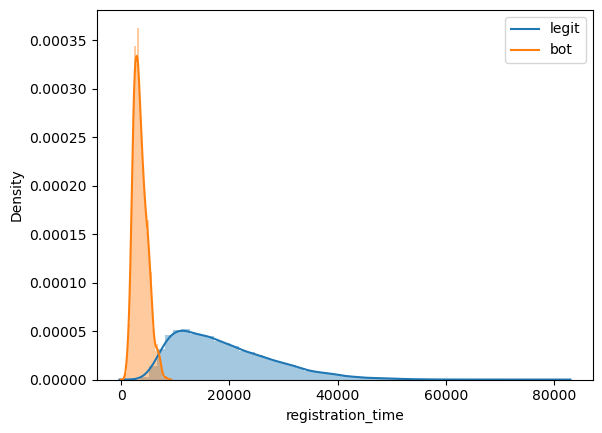

In [22]:
sns.distplot(df[df['new_label'] == 'legit']['registration_time'])
sns.distplot(df[df['new_label'] == 'fraud']['registration_time'])
plt.legend(labels=['legit', 'bot'])

Then, the same is done for the randomness of the user names:

/tmp/ipykernel_10815/2688275694.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['new_label'] == 'legit']['randomness_uname'])
/tmp/ipykernel_10815/2688275694.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['new_label'] == 'fraud']['randomness_uname'])


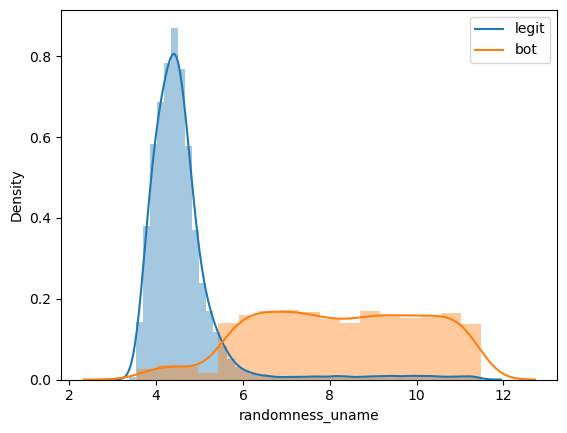

In [23]:
sns.distplot(df[df['new_label'] == 'legit']['randomness_uname'])
sns.distplot(df[df['new_label'] == 'fraud']['randomness_uname'])
plt.legend(labels=['legit', 'bot'])